Pyro examples page https://pyro.ai/examples/

Source: https://robsalomone.com/course-deep-probabilistic-models/

But I took a left turn at Albuquerque.

In [ ]:
pip install pyro-ppl

     |████████████████████████████████| 718 kB 5.2 MB/s 
     |████████████████████████████████| 750.6 MB 10 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.11.1+cu111 requires torch==1.10.0, but you have torch 1.11.0 which is incompatible.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.11.0 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.11.0 which is incompatible.


In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from torch.distributions import constraints
from torch import tensor

import pyro
import pyro.distributions as dist
from pyro.infer import Predictive, SVI, Trace_ELBO, NUTS, MCMC
from pyro.infer.autoguide import AutoNormal, AutoMultivariateNormal, init_to_mean
from pyro.optim import Adam


pyro.set_rng_seed(1)

torch.manual_seed(1)
plt.rcParams['figure.figsize'] = [12, 8]

In [ ]:
# from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris

X, y = load_iris(as_frame=True, return_X_y=True)

In [ ]:
X['target'] = y
X.columns

Index(['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)',
       'petal width (cm)', 'target'],
      dtype='object')

In [ ]:
target_names = ['setosa', 'versicolor', 'virginica']

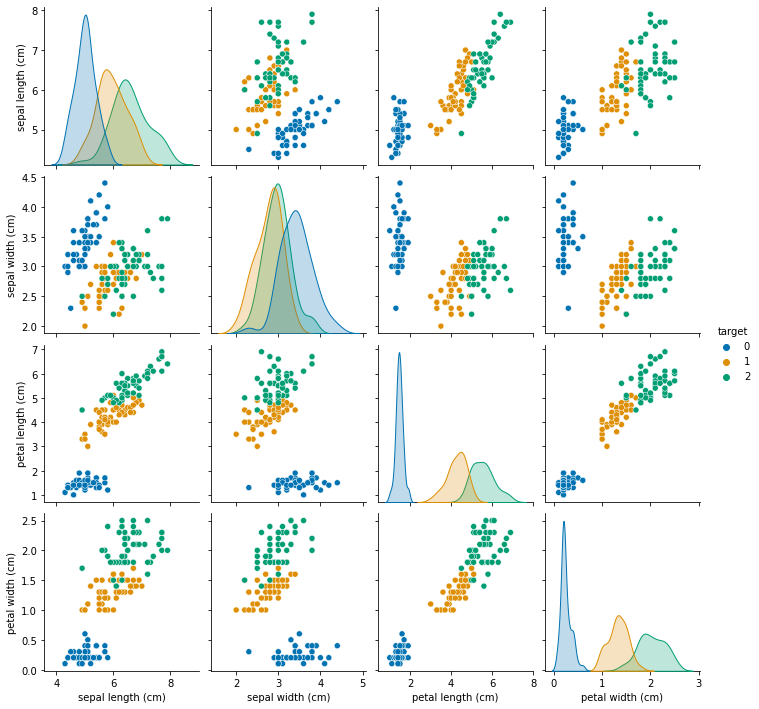

In [ ]:
sns.pairplot(data=X, hue='target', palette="colorblind") #setosa is easy to distinguish, versicolor and virginica are harder

In [ ]:
X_ = tensor(X.values)

In [ ]:
data = X_[:,2]
target = X_[:,4]
data_column_names = X.columns[2]
data_column_names

'petal length (cm)'

In [ ]:
# So this dataset gives us a lot of different data to model

# Let's start off with a simple linear regression and let's model petal width as a function of petal length


def model_1(data, target, data_column_names):
    intercept_prior = 0.0 # goes through the origin. If it didn't, add a dist for the intercept prior

    beta = pyro.sample("beta", dist.Uniform(0., 2.))

    estimate = intercept_prior + (data * beta)
    
    sigma_1 = pyro.sample('sigma',dist.Exponential(0.25)) #sigma prior

    with pyro.plate('data', target.size(0)):
      pyro.sample('obs', dist.Normal(estimate, sigma_1), obs=target)



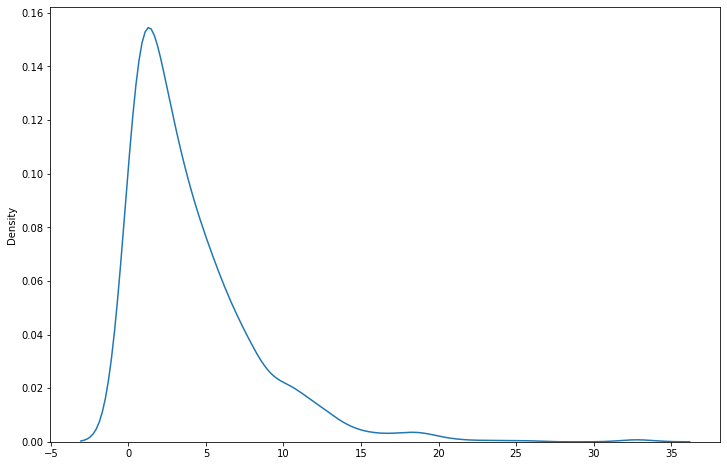

In [ ]:
#Aside Why Exponential(0.25) for the sigma prior?

sns.kdeplot(dist.Exponential(0.25).sample([1000]))

In [ ]:
guide = AutoMultivariateNormal(model_1) #pyro has a convenient set of autoguides available. One can also write custom guides.

def train(model, guide, lr=0.01, n_steps=2500):
    pyro.set_rng_seed(1)
    pyro.clear_param_store()
    
    gamma = 0.1  # final learning rate will be gamma * initial_lr
    lrd = gamma ** (1 / n_steps)
    adam = pyro.optim.ClippedAdam({'lr': lr, 'lrd': lrd})

    svi = SVI(model, guide, adam, loss=Trace_ELBO())

    for i in range(n_steps):
        elbo = svi.step(data, target, data_column_names)
        if i % 500 == 0:
          print(f"Elbo loss: {elbo}")

In [ ]:
%%time
train(model_1, guide) #Question: Should I train my guide for more steps? Why or why not?

Elbo loss: 557.9726012754423
Elbo loss: 76.35474583068226
Elbo loss: 76.3215976825409
Elbo loss: 76.27334903721697
Elbo loss: 76.11254055825933
CPU times: user 12.6 s, sys: 81.1 ms, total: 12.7 s
Wall time: 15.9 s


In [ ]:
from pyro.infer import Predictive

num_samples = 1000
predictive = Predictive(model_1, guide=guide, num_samples=num_samples)

svi_samples = {k: v.reshape(num_samples).detach().cpu().numpy()
               for k, v in predictive(data, target, data_column_names).items()
               if k != "obs"}

In [ ]:
svi_samples.keys()

dict_keys(['beta', 'sigma'])

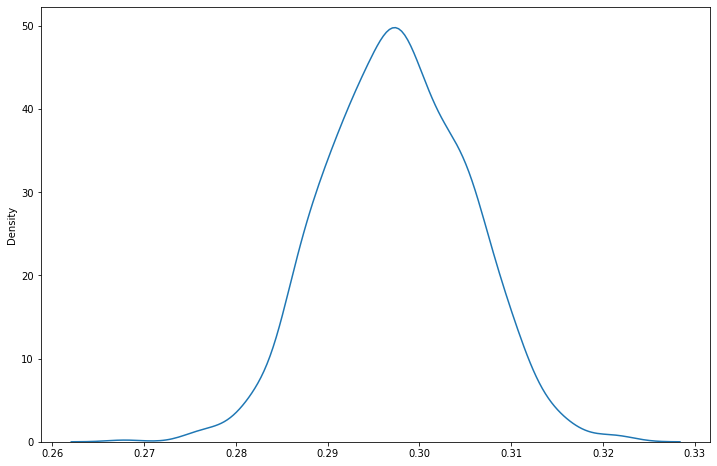

In [ ]:
sns.kdeplot(svi_samples['beta'])

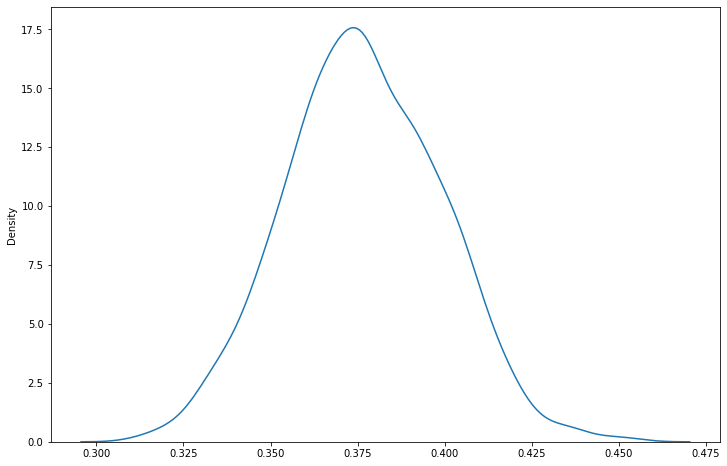

In [ ]:
sns.kdeplot(svi_samples['sigma'])

(0.0, 7.0)

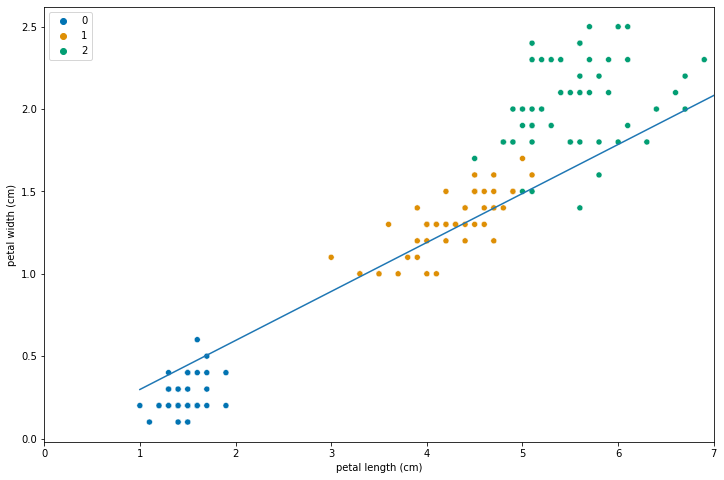

In [ ]:
xx = np.linspace(1,7,50)
yy = (svi_samples['beta'].mean()) * xx #draw a line through the mean of the slope estimates
ax = sns.scatterplot(x='petal length (cm)', y='petal width (cm)', palette='colorblind', hue='target', data=X)
sns.lineplot(x=xx, y=yy, ax=ax)
plt.xlim(0,7)

In [ ]:
# What about MCMC?
from pyro.infer import MCMC, NUTS
nuts_kernel = NUTS(model_1)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200)

In [ ]:
%%time
mcmc.run(data, target, data_column_names)

Sample: 100%|██████████| 1200/1200 [00:09, 129.92it/s, step size=1.22e+00, acc. prob=0.886]

CPU times: user 9.13 s, sys: 86.8 ms, total: 9.22 s
Wall time: 9.25 s


In [ ]:
hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

In [ ]:
hmc_samples.keys()

dict_keys(['beta', 'sigma'])

(0.0, 7.0)

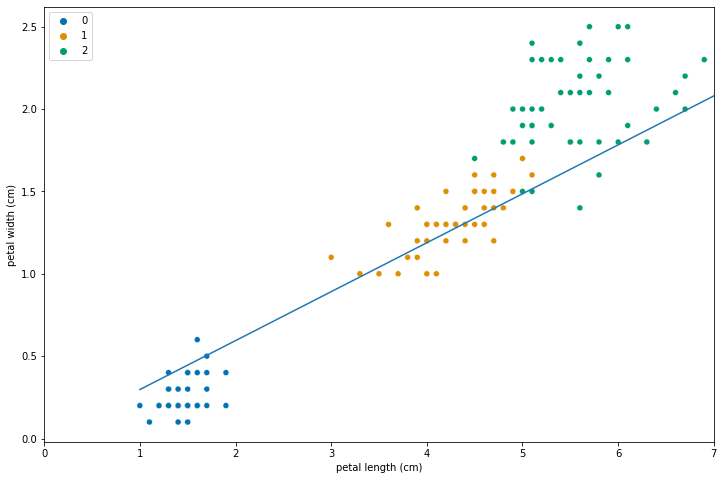

In [ ]:
xx = np.linspace(1,7,50)
yy_mean = (hmc_samples['beta'].mean()) * xx
sns.scatterplot(x='petal length (cm)', y='petal width (cm)', palette='colorblind', hue='target', data=X)
sns.lineplot(x=xx, y=yy_mean)
plt.xlim(0,7)

## Footnotes
### Notice that I did not center the data. This is a no-no! 
*Always center your data*! Do as I say, not as I do.
Centering the data helps you properly interpret the parameters of the (multiple) linear regression. 
Centering might also help model convergence in general, although since the variables are all the same order of magnitude, probably would not matter in this case

### Notice that I calculated the MEAN slope of the posterior samples. 
If you re-did this using scikit learn or statsmodels OLS, you would retrieve the **maximium likelihood estimate** of the slope. The answer retrieved would be 'close' to our answer above, but different! 

## Future work
1 - Calculate the maximium likelihood estimate for the slope (see pyro docs https://pyro.ai/examples/mle_map.html )

2 - I assert that a straight line is probably not the *best* way to fit this data. 
  
  Try fitting petal width  = Beta_1 * petal length + Beta_2 * (petal length)^2 

  Try fitting petal width  = Beta_1 * petal length + Beta_2 * sepal width + Beta_3 * sepal length + Beta_4 * species

3 - Do some of the traditional things done with the IRIS dataset, e.g. building a logistic regression classifier to predict the species.

In [ ]:
#Final Note:  there is no free lunch! MCMC is generally much slower for big data.

#HOWEVER, If you need a more exact answer of where the posterior lies, use MCMC, since MCMC does a better job than SVI and the autoguides.
# If you want to use SVI you're going to have to pay close attention to the construction of your guide!
# That's all I'll say about SVI and guides for now. Come back in a few weeks when I know more!

In [ ]:
# model code for arbitrary number of betas
# this is ugly code but you get the point

def model_2(data, target, data_column_names):
    intercept_prior = 0.0 # goes through the origin
    linear_combination = intercept_prior #sample the intercept prior here if it is not zero

    try:
      shape = data.size(1) # number of columns
      for i in range(shape):
          coefficient_prior = dist.Uniform(0., 3.) #can give each coefficient different prior distributions here
          beta_coef = pyro.sample(f"beta_{data_column_names.tolist()[i]}", coefficient_prior)
          linear_combination = linear_combination + (data[:, i] * beta_coef)

    except IndexError:
      #no loop needed, only one column
      coefficient_prior = dist.Uniform(0., 2.)
      beta_coef = pyro.sample(f"beta_{data_column_names}", coefficient_prior)
      linear_combination = linear_combination + (data * beta_coef)

    sigma_1 = pyro.sample('sigma',pyro.distributions.Exponential(0.25)) #sigma prior
    estimate = linear_combination

    with pyro.plate('data', target.size(0)):
      pyro.sample('obs', dist.Normal(estimate, sigma_1), obs=target)

